In [1]:
# Configure the necessary Spark environment
import os
import sys

# Spark home
spark_home = os.environ.get("SPARK_HOME")

# If Spark V1.4.x is detected, then add ' pyspark-shell' to
# the end of the 'PYSPARK_SUBMIT_ARGS' environment variable
spark_release_file = spark_home + "/RELEASE"
if os.path.exists(spark_release_file) and "Spark 1.4" in open(spark_release_file).read():
    pyspark_submit_args = os.environ.get("PYSPARK_SUBMIT_ARGS", "")
    if not "pyspark-shell" in pyspark_submit_args: pyspark_submit_args += " pyspark-shell"
    os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

# Add the spark python sub-directory to the path
sys.path.insert(0, spark_home + "/python")

# Add the py4j to the path.
# You may need to change the version number to match your install
sys.path.insert(0, os.path.join(spark_home, "python/lib/py4j-0.8.2.1-src.zip"))

# Initialize PySpark to predefine the SparkContext variable 'sc'
execfile(os.path.join(spark_home, "python/pyspark/shell.py"))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.2.0
      /_/

Using Python version 2.7.13 (default, Dec 20 2016 23:05:08)
SparkSession available as 'spark'.


## IRIS data set

In [55]:
# Load the library with the iris dataset
from sklearn.datasets import load_iris

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

# Load pandas
import pandas as pd

# Load numpy
import numpy as np

# Set random seed
np.random.seed(0)

In [56]:
# Create an object called iris with the iris data
iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [57]:
# Add a new column with the species names, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [58]:
# Create a new column that for each row, generates a random number between 0 and 1, and
# if that value is less than or equal to .75, then sets the value of that cell as True
# and false otherwise. This is a quick and dirty way of randomly assigning some rows to
# be used as the training data and some as the test data.
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,setosa,True
1,4.9,3.0,1.4,0.2,setosa,True
2,4.7,3.2,1.3,0.2,setosa,True
3,4.6,3.1,1.5,0.2,setosa,True
4,5.0,3.6,1.4,0.2,setosa,True


In [59]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [60]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

('Number of observations in the training data:', 118)
('Number of observations in the test data:', 32)


In [61]:
# Create a list of the feature column's names
features = df.columns[:4]

# View features
features

Index([u'sepal length (cm)', u'sepal width (cm)', u'petal length (cm)',
       u'petal width (cm)'],
      dtype='object')

In [62]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.
y = pd.factorize(train['species'])[0]

# View target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

In [63]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [64]:
# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
clf.predict(test[features])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [65]:
# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[0:10]

array([[ 1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 0.9,  0.1,  0. ],
       [ 1. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ]])

In [66]:
#Evaluate Classifier
# Create actual english names for the plants for each predicted plant class
preds = iris.target_names[clf.predict(test[features])]

In [67]:
# View the PREDICTED species for the first five observations
preds[0:5]

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa'], 
      dtype='|S10')

In [68]:
# View the ACTUAL species for the first five observations
test['species'].head()

7     setosa
8     setosa
10    setosa
13    setosa
17    setosa
Name: species, dtype: category
Categories (3, object): [setosa, versicolor, virginica]

In [69]:
# Create confusion matrix
pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,setosa,versicolor,virginica
Actual Species,,,
setosa,13,0,0
versicolor,0,5,2
virginica,0,0,12


In [70]:
# View a list of the features and their importance scores
list(zip(train[features], clf.feature_importances_))

[('sepal length (cm)', 0.11185992930506346),
 ('sepal width (cm)', 0.016341813006098178),
 ('petal length (cm)', 0.36439533040889194),
 ('petal width (cm)', 0.5074029272799464)]

Reference:
https://spark.apache.org/docs/2.1.0/mllib-ensembles.html#random-forests

# Random Forests
Random forests are ensembles of decision trees. Random forests are one of the most successful machine learning models for classification and regression. They combine many decision trees in order to reduce the risk of overfitting. Like decision trees, random forests handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

spark.mllib supports random forests for binary and multiclass classification and for regression, using both continuous and categorical features. spark.mllib implements random forests using the existing decision tree implementation. Please see the decision tree guide for more information on trees.

## Basic algorithm
Random forests train a set of decision trees separately, so the training can be done in parallel. The algorithm injects randomness into the training process so that each decision tree is a bit different. Combining the predictions from each tree reduces the variance of the predictions, improving the performance on test data.

## Training

The randomness injected into the training process includes:

Subsampling the original dataset on each iteration to get a different training set (a.k.a. bootstrapping).
Considering different random subsets of features to split on at each tree node.
Apart from these randomizations, decision tree training is done in the same way as for individual decision trees.

## Prediction

To make a prediction on a new instance, a random forest must aggregate the predictions from its set of decision trees. This aggregation is done differently for classification and regression.

## Classification:
Majority vote. Each tree’s prediction is counted as a vote for one class. The label is predicted to be the class which receives the most votes.

## Regression: 
Averaging. Each tree predicts a real value. The label is predicted to be the average of the tree predictions.

## Usage tips
We include a few guidelines for using random forests by discussing the various parameters. We omit some decision tree parameters since those are covered in the decision tree guide.

The first two parameters we mention are the most important, and tuning them can often improve performance:

### numTrees: Number of trees in the forest.
Increasing the number of trees will decrease the variance in predictions, improving the model’s test-time accuracy.
Training time increases roughly linearly in the number of trees.
### maxDepth: Maximum depth of each tree in the forest.
Increasing the depth makes the model more expressive and powerful. However, deep trees take longer to train and are also more prone to overfitting.

In general, it is acceptable to train deeper trees when using random forests than when using a single decision tree. One tree is more likely to overfit than a random forest (because of the variance reduction from averaging multiple trees in the forest).
The next two parameters generally do not require tuning. However, they can be tuned to speed up training.

### subsamplingRate: 
This parameter specifies the size of the dataset used for training each tree in the forest, as a fraction of the size of the original dataset. The default (1.0) is recommended, but decreasing this fraction can speed up training.

### featureSubsetStrategy: 
Number of features to use as candidates for splitting at each tree node. The number is specified as a fraction or function of the total number of features. Decreasing this number will speed up training, but can sometimes impact performance if too low.


In [ ]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

# Load and parse the data file into an RDD of LabeledPoint.
data = MLUtils.loadLibSVMFile(sc, 'data/mllib/sample_libsvm_data.txt')

In [80]:
data.take(1)

[LabeledPoint(0.0, (692,[127,128,129,130,131,154,155,156,157,158,159,181,182,183,184,185,186,187,188,189,207,208,209,210,211,212,213,214,215,216,217,235,236,237,238,239,240,241,242,243,244,245,262,263,264,265,266,267,268,269,270,271,272,273,289,290,291,292,293,294,295,296,297,300,301,302,316,317,318,319,320,321,328,329,330,343,344,345,346,347,348,349,356,357,358,371,372,373,374,384,385,386,399,400,401,412,413,414,426,427,428,429,440,441,442,454,455,456,457,466,467,468,469,470,482,483,484,493,494,495,496,497,510,511,512,520,521,522,523,538,539,540,547,548,549,550,566,567,568,569,570,571,572,573,574,575,576,577,578,594,595,596,597,598,599,600,601,602,603,604,622,623,624,625,626,627,628,629,630,651,652,653,654,655,656,657],[51.0,159.0,253.0,159.0,50.0,48.0,238.0,252.0,252.0,252.0,237.0,54.0,227.0,253.0,252.0,239.0,233.0,252.0,57.0,6.0,10.0,60.0,224.0,252.0,253.0,252.0,202.0,84.0,252.0,253.0,122.0,163.0,252.0,252.0,252.0,253.0,252.0,252.0,96.0,189.0,253.0,167.0,51.0,238.0,253.0,253.0,190.0

In [74]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Note: Use larger numTrees in practice.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification forest model:')
print(model.toDebugString())

Test Error = 0.03125
Learned classification forest model:
TreeEnsembleModel classifier with 3 trees

  Tree 0:
    If (feature 433 <= 0.0)
     If (feature 627 <= 0.0)
      Predict: 1.0
     Else (feature 627 > 0.0)
      Predict: 0.0
    Else (feature 433 > 0.0)
     Predict: 1.0
  Tree 1:
    If (feature 406 <= 0.0)
     Predict: 0.0
    Else (feature 406 > 0.0)
     If (feature 482 <= 0.0)
      If (feature 376 <= 237.0)
       Predict: 1.0
      Else (feature 376 > 237.0)
       Predict: 0.0
     Else (feature 482 > 0.0)
      Predict: 0.0
  Tree 2:
    If (feature 405 <= 0.0)
     Predict: 0.0
    Else (feature 405 > 0.0)
     If (feature 273 <= 0.0)
      Predict: 1.0
     Else (feature 273 > 0.0)
      Predict: 0.0



In [81]:
data.take(1)

[LabeledPoint(0.0, (692,[127,128,129,130,131,154,155,156,157,158,159,181,182,183,184,185,186,187,188,189,207,208,209,210,211,212,213,214,215,216,217,235,236,237,238,239,240,241,242,243,244,245,262,263,264,265,266,267,268,269,270,271,272,273,289,290,291,292,293,294,295,296,297,300,301,302,316,317,318,319,320,321,328,329,330,343,344,345,346,347,348,349,356,357,358,371,372,373,374,384,385,386,399,400,401,412,413,414,426,427,428,429,440,441,442,454,455,456,457,466,467,468,469,470,482,483,484,493,494,495,496,497,510,511,512,520,521,522,523,538,539,540,547,548,549,550,566,567,568,569,570,571,572,573,574,575,576,577,578,594,595,596,597,598,599,600,601,602,603,604,622,623,624,625,626,627,628,629,630,651,652,653,654,655,656,657],[51.0,159.0,253.0,159.0,50.0,48.0,238.0,252.0,252.0,252.0,237.0,54.0,227.0,253.0,252.0,239.0,233.0,252.0,57.0,6.0,10.0,60.0,224.0,252.0,253.0,252.0,202.0,84.0,252.0,253.0,122.0,163.0,252.0,252.0,252.0,253.0,252.0,252.0,96.0,189.0,253.0,167.0,51.0,238.0,253.0,253.0,190.0

In [5]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Note: Use larger numTrees in practice.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification forest model:')
print(model.toDebugString())

# Save and load model
#model.save(sc, "target/tmp/myRandomForestClassificationModel")
#sameModel = RandomForestModel.load(sc, "target/tmp/myRandomForestClassificationModel")

Test Error = 0.0
Learned classification forest model:
TreeEnsembleModel classifier with 3 trees

  Tree 0:
    If (feature 435 <= 0.0)
     If (feature 405 <= 0.0)
      Predict: 0.0
     Else (feature 405 > 0.0)
      If (feature 486 <= 0.0)
       Predict: 1.0
      Else (feature 486 > 0.0)
       Predict: 0.0
    Else (feature 435 > 0.0)
     Predict: 1.0
  Tree 1:
    If (feature 244 <= 0.0)
     If (feature 382 <= 61.0)
      Predict: 1.0
     Else (feature 382 > 61.0)
      Predict: 0.0
    Else (feature 244 > 0.0)
     If (feature 433 <= 0.0)
      Predict: 0.0
     Else (feature 433 > 0.0)
      Predict: 1.0
  Tree 2:
    If (feature 461 <= 0.0)
     If (feature 512 <= 0.0)
      If (feature 265 <= 101.0)
       Predict: 0.0
      Else (feature 265 > 101.0)
       Predict: 1.0
     Else (feature 512 > 0.0)
      Predict: 0.0
    Else (feature 461 > 0.0)
     Predict: 1.0




Main function
:return:

('DecisionTree with features', [0, 1], 'has a score of', 0.92666666666666664)
('RandomForest with 30 estimators with features', [0, 1], 'has a score of', 0.92666666666666664)
('DecisionTree with features', [0, 2], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('DecisionTree with features', [2, 3], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [2, 3], 'has a score of', 0.99333333333333329)


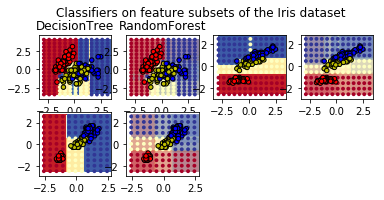

In [77]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()


## UCI breast cancer dataset 

Q: Where to get teh data: 
a. You can download the data from UCI 
b. You can download the code from Dataaspirant Github.

This breast cancer dataset is the most popular classification dataset. Which is having 10 features and 1 target class.

### Breast Cancer dataset features:

* having 10 features and 1 target class.

### Sample code number:
id number

### Clump Thickness:
The values are in the range of 1 – 10

### Uniformity of Cell Size:
The values are in the range of 1 – 10

### Uniformity of Cell Shape:
The values are in the range of  1 – 10

### Marginal Adhesion:
The values are in the range of 1 – 10

### Single Epithelial Cell Size:
The values are in the range of  1 – 10

### Bare Nuclei:
The values are in the range of  1 – 10

### Bland Chromatin:
The values are in the range of  1 – 10

### Normal Nucleoli:
The values are in the range of  1 – 10

### Mitoses:
The values are in the range of  1 – 10

## Target Class
The target class having two target classes

Bening
The value will be 2
Malignant
The value will be 4


In [15]:
!cd /Users/tuhinm/datasets/inputs;pwd;wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

/Users/tuhinm/datasets/inputs
--2017-09-05 20:46:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19889 (19K) [text/plain]
Saving to: ‘breast-cancer-wisconsin.data’

breast-cancer-wisco 100%[===================>]  19.42K  --.-KB/s    in 0.07s   

2017-09-05 20:46:49 (273 KB/s) - ‘breast-cancer-wisconsin.data’ saved [19889/19889]



In [19]:
# Required Python Packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Required Python Packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [48]:
INPUT_PATH = "/Users/tuhinm/datasets/inputs/breast-cancer-wisconsin.data"
OUTPUT_PATH = "/Users/tuhinm/datasets/inputs/breast-cancer-wisconsin.csv"
 

In [49]:

# Required Python Packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
 
import pdb
 

# Headers
HEADERS = ["CodeNumber", "ClumpThickness", "UniformityCellSize", "UniformityCellShape", "MarginalAdhesion",
           "SingleEpithelialCellSize", "BareNuclei", "BlandChromatin", "NormalNucleoli", "Mitoses", "CancerType"]
 
def read_data(path):
    """
    Read the data into pandas dataframe
    :param path:
    :return:
    """
    data = pd.read_csv(path)
    return data
 
def get_headers(dataset):
    """
    dataset headers
    :param dataset:
    :return:
    """
    return dataset.columns.values
 
def add_headers(dataset, headers):
    """
    Add the headers to the dataset
    :param dataset:
    :param headers:
    :return:
    """
    dataset.columns = headers
    return dataset
 
def data_file_to_csv():
    """
 
    :return:
    """
 
    # Headers
    headers = ["CodeNumber", "ClumpThickness", "UniformityCellSize", "UniformityCellShape", "MarginalAdhesion",
               "SingleEpithelialCellSize", "BareNuclei", "BlandChromatin", "NormalNucleoli", "Mitoses",
               "CancerType"]
    # Load the dataset into Pandas data frame
    dataset = read_data(INPUT_PATH)
    # Add the headers to the loaded dataset
    dataset = add_headers(dataset, headers)
    # Save the loaded dataset into csv format
    dataset.to_csv(OUTPUT_PATH, index=False)
    print "File saved ...!"
 
 
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    :param dataset:
    :param train_percentage:
    :param feature_headers:
    :param target_header:
    :return: train_x, test_x, train_y, test_y
    """
 
    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y
 
def handel_missing_values(dataset, missing_values_header, missing_label):
    """
    Filter missing values from the dataset
    :param dataset:
    :param missing_values_header:
    :param missing_label:
    :return:
    """
 
    return dataset[dataset[missing_values_header] != missing_label]
 
def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf
 
def dataset_statistics(dataset):
    """
    Basic statistics of the dataset
    :param dataset: Pandas dataframe
    :return: None, print the basic statistics of the dataset
    """
    print dataset.describe()
 
 
def main():
    """
    Main function
    :return:
    """
    # Load the csv file into pandas dataframe
    dataset = pd.read_csv(OUTPUT_PATH)
    # Get basic statistics of the loaded dataset
    dataset_statistics(dataset)
 
    # Filter missing values
    dataset = handel_missing_values(dataset, HEADERS[6], '?')
    train_x, test_x, train_y, test_y = split_dataset(dataset, 0.7, HEADERS[1:-1], HEADERS[-1])
 
    # Train and Test dataset size details
    print "Train_x Shape :: ", train_x.shape
    print "Train_y Shape :: ", train_y.shape
    print "Test_x Shape :: ", test_x.shape
    print "Test_y Shape :: ", test_y.shape
 
    # Create random forest classifier instance
    trained_model = random_forest_classifier(train_x, train_y)
    print "Trained model :: ", trained_model
    predictions = trained_model.predict(test_x)
 
    for i in xrange(0, 5):
        print "Actual outcome :: {} and Predicted outcome :: {}".format(list(test_y)[i], predictions[i])
 
    print "Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x))
    print "Test Accuracy  :: ", accuracy_score(test_y, predictions)
    print " Confusion matrix ", confusion_matrix(test_y, predictions)

In [51]:
data_file_to_csv()

File saved ...!


In [52]:
main()

         CodeNumber  ClumpThickness  UniformityCellSize  UniformityCellShape  \
count  6.980000e+02      698.000000          698.000000           698.000000   
mean   1.071807e+06        4.416905            3.137536             3.210602   
std    6.175323e+05        2.817673            3.052575             2.972867   
min    6.163400e+04        1.000000            1.000000             1.000000   
25%    8.702582e+05        2.000000            1.000000             1.000000   
50%    1.171710e+06        4.000000            1.000000             1.000000   
75%    1.238354e+06        6.000000            5.000000             5.000000   
max    1.345435e+07       10.000000           10.000000            10.000000   

       MarginalAdhesion  SingleEpithelialCellSize  BlandChromatin  \
count        698.000000                698.000000      698.000000   
mean           2.809456                  3.217765        3.438395   
std            2.856606                  2.215408        2.440056   
min